In [1]:
%config InlineBackend.figure_format = "svg"

# Data processing imports
from scipy.optimize import fmin_slsqp, curve_fit
import pandas as pd
import numpy as np

# Data visualization imports
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Import clustered data

In [2]:
df = pd.read_csv("my_data/clustered_pcd.csv")
df

,x,y,z,nx,ny,nz,cluster,tread
0,-0.002940,-0.04294,0.290140,-0.326147,0.045403,0.944228,0,True
1,0.138690,-0.05471,0.397650,0.826433,-0.048764,-0.560919,6,False
2,0.146500,-0.00176,0.394075,0.804035,-0.001458,-0.594581,1,True
3,0.044395,-0.00903,0.309410,-0.437302,0.408187,0.801343,1,True
4,0.056847,-0.12176,0.330673,-0.613172,0.360063,0.703118,2,True
...,...,...,...,...,...,...,...,...
43914,-0.108820,0.03000,0.269220,-0.033776,-0.142515,0.989216,4,True
43915,-0.106470,0.03000,0.269310,-0.047981,-0.125475,0.990936,4,True
43916,-0.128820,0.03000,0.269370,0.005268,-0.056899,0.998366,4,True
43917,-0.127650,0.03000,0.269360,0.000712,-0.063930,0.997954,4,True


## Calculate rotation axis unit vector

In [3]:
# Filter dataframe according to good tread clusters
clusters = [0, 1]

def residual(normal):
    # Get dataframe normals
    normals = df.query(f"cluster in {clusters}")[["nx", "ny", "nz"]].values
    # Calculate dot product between them
    resids = np.dot(normals, normal)
    # Calculate least squares
    resid = (resids**2).sum()
    return resid

def constraint(normal):
    # The normal vector should be unitary
    norm = (normal**2).sum()
    resid = 1 - norm
    return resid
   
# Best orientation
axis_vec = fmin_slsqp(residual, [0,1,0], [constraint], acc=1e-12)
axis_vec

Optimization terminated successfully    (Exit mode 0)
            Current function value: 303.37044197644536
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


array([ 0.0039864 ,  0.99942532, -0.03366211])

## Calculate vectors that span the rotation plane

In [4]:
def project(point, normal, center=np.array([0,0,0])):
    # Calculate vector from center to point
    point = point - center
    # Calculate length of paralel component
    dist = np.dot(point, normal)
    # Remove paralel component
    point = point - dist * normal
    return point

# Calculate arrays defining rotation plane
u, v = project(np.array([1,0,0]), axis_vec), project(np.array([0,0,1]), axis_vec)
u, v = u / np.sqrt((u**2).sum()), v / np.sqrt((v**2).sum())
u, v

(array([ 9.99992054e-01, -3.98413616e-03,  1.34191545e-04]),
 array([1.34266571e-04, 3.36618417e-02, 9.99433271e-01]))

## Project points to rotation plane

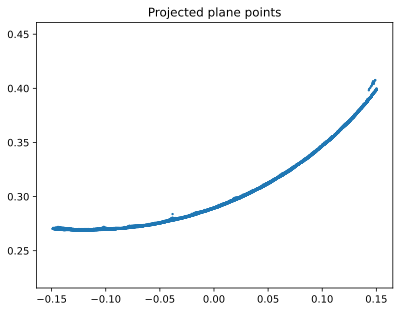

In [5]:
# Calculate projected points
circle_df = df.query(f"cluster in {clusters}")
proj_points = np.array([project(p, axis_vec) for p in circle_df[["x","y","z"]].values])

# Calculate u and v coordinates in projected plane
a, b = np.dot(proj_points, u), np.dot(proj_points, v)
uv_points = np.stack([a, b], axis=1)

# Plot those points
plt.title("Projected plane points")
plt.scatter(uv_points[:,0], uv_points[:,1], s=2)
plt.axis("equal")
plt.show()

## Fit circle to points in the rotation plane

The equation for our circle will be given by:
$$ (u - u_0)^2 + (v - v_0)^2 = r^2 $$

Where (u_0, v_0) represent the center coordinates of our axis of rotation (in the rotation plane) and $r$ the radius of the circunference.

We can linearlize the circle equation into the following one:
$$ 2u_0u + 2v_0v + r^2 - u_0^2 - v_0^2 = u^2 + v^2 $$

This linearization makes it easier to use a `least_squares` method to extract the axis of rotation.

In [6]:
# Fit circle to data
def circle_fit(u, v):
    # Function to fit to circle data
    f = lambda u, u0, v0, r: 2*u0*u + 2*v0*v + r**2 - u0**2 - v0**2
    
    # Get the A, B, C fitted parameters
    params, _ = curve_fit(f, u, u**2 + v**2, ftol=1e-12)
    u0, v0, r = params
    
    # Determine center and radius from parameters
    c, r = np.array([u0, v0]), np.abs(r)
    
    return c, r

# Calculate center and radius in projected coordinates
c, r = circle_fit(uv_points[:,0], uv_points[:,1])
c, r

(array([-0.11438361,  0.60488765]), 0.33557108016802417)

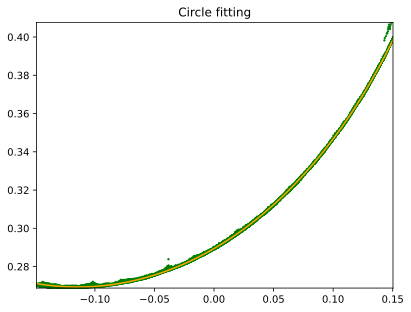

In [7]:
# Plot circle and datapoints
angles = np.linspace(0, 2*np.pi, 1000)
circle_x = c[0] + r * np.cos(angles)
circle_y = c[1] + r * np.sin(angles)

# Plot angles and fitting points
plt.title("Circle fitting")
plt.plot(circle_x, circle_y, color="orange")
plt.scatter(uv_points[:,0], uv_points[:,1], color="green", s=2)
plt.xlim(uv_points[:,0].min(), uv_points[:,0].max())
plt.ylim(uv_points[:,1].min(), uv_points[:,1].max())
# plt.axis("equal")
plt.show()

## Project all point cloud points to rotation plane

In [8]:
uv_projections = np.array([project(p, axis_vec) for p in df[["x","y","z"]].values])
a, b = np.dot(uv_projections, u), np.dot(uv_projections, v)
uv_projections = np.stack([a, b], axis=1)
uv_projections

array([[-0.00272996,  0.28852973],
       [ 0.13896023,  0.39560162],
       [ 0.14655873,  0.39381209],
       ...,
       [-0.12890235,  0.2702099 ],
       [-0.12773236,  0.27020006],
       [-0.12537238,  0.27020038]])

## Calculate depth from distance of projections to circle center

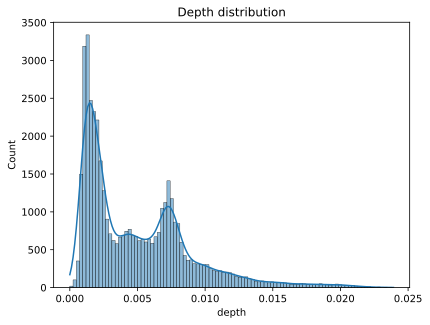

In [9]:
# Calculate vector differences between projected points and circle center
diff = np.array([p - c for p in uv_projections])

# Calculate norm of each vector
dists = np.sqrt( (diff**2).sum(axis=1) )

# Turn distances into depths and add them to dataframe
depths = dists.max() - dists
df["depth"] = depths

# Plot distribution of depths
plt.title("Depth distribution")
sns.histplot(df, x="depth", bins=100, kde=True)
plt.show()

## Save new dataframe with depths

In [10]:
df.to_csv("my_data/depth_pcd.csv", index=False)